<a href="https://colab.research.google.com/github/Soumyad13/Anomaly-Detection-in-Network-Traffic-using-Isolation-Forest-and-Autoencoders/blob/main/Anamoly_Detection_in_Network_Traffic_%5BWEEK1_CELEBAL_PROJECT%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Isolation Forest

In [28]:
import kagglehub
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


LOAD DATASET KDD Cup 1999 Data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("galaxyh/kdd-cup-1999-data")

print("Path to dataset files:", path)

100%|██████████| 87.8M/87.8M [00:02<00:00, 33.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/galaxyh/kdd-cup-1999-data/versions/1


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Download dataset
import kagglehub
import shutil
import os

# Step 1: Download using kagglehub
path = kagglehub.dataset_download("galaxyh/kdd-cup-1999-data")

# Step 2: Copy to Google Drive
dst = "/content/drive/MyDrive/kddcup_dataset"
os.makedirs(dst, exist_ok=True)
shutil.copy(os.path.join(path, "kddcup.data_10_percent_corrected"), dst)

# Step 3: Load into DataFrame
data = pd.read_csv(os.path.join(dst, "kddcup.data_10_percent_corrected"), header=None)

# Optional: print info
print("DataFrame loaded:", data.shape)
data.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DataFrame loaded: (494021, 42)


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       494021 non-null  int64  
 1   1       494021 non-null  object 
 2   2       494021 non-null  object 
 3   3       494021 non-null  object 
 4   4       494021 non-null  int64  
 5   5       494021 non-null  int64  
 6   6       494021 non-null  int64  
 7   7       494021 non-null  int64  
 8   8       494021 non-null  int64  
 9   9       494021 non-null  int64  
 10  10      494021 non-null  int64  
 11  11      494021 non-null  int64  
 12  12      494021 non-null  int64  
 13  13      494021 non-null  int64  
 14  14      494021 non-null  int64  
 15  15      494021 non-null  int64  
 16  16      494021 non-null  int64  
 17  17      494021 non-null  int64  
 18  18      494021 non-null  int64  
 19  19      494021 non-null  int64  
 20  20      494021 non-null  int64  
 21  21      49

In [ ]:
# (Number of entries, Number of features)
print(data.shape)

(494021, 42)


In [ ]:
data.describe()

,0,4,5,6,7,8,9,10,11,12,...,31,32,33,34,35,36,37,38,39,40
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,...,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,...,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


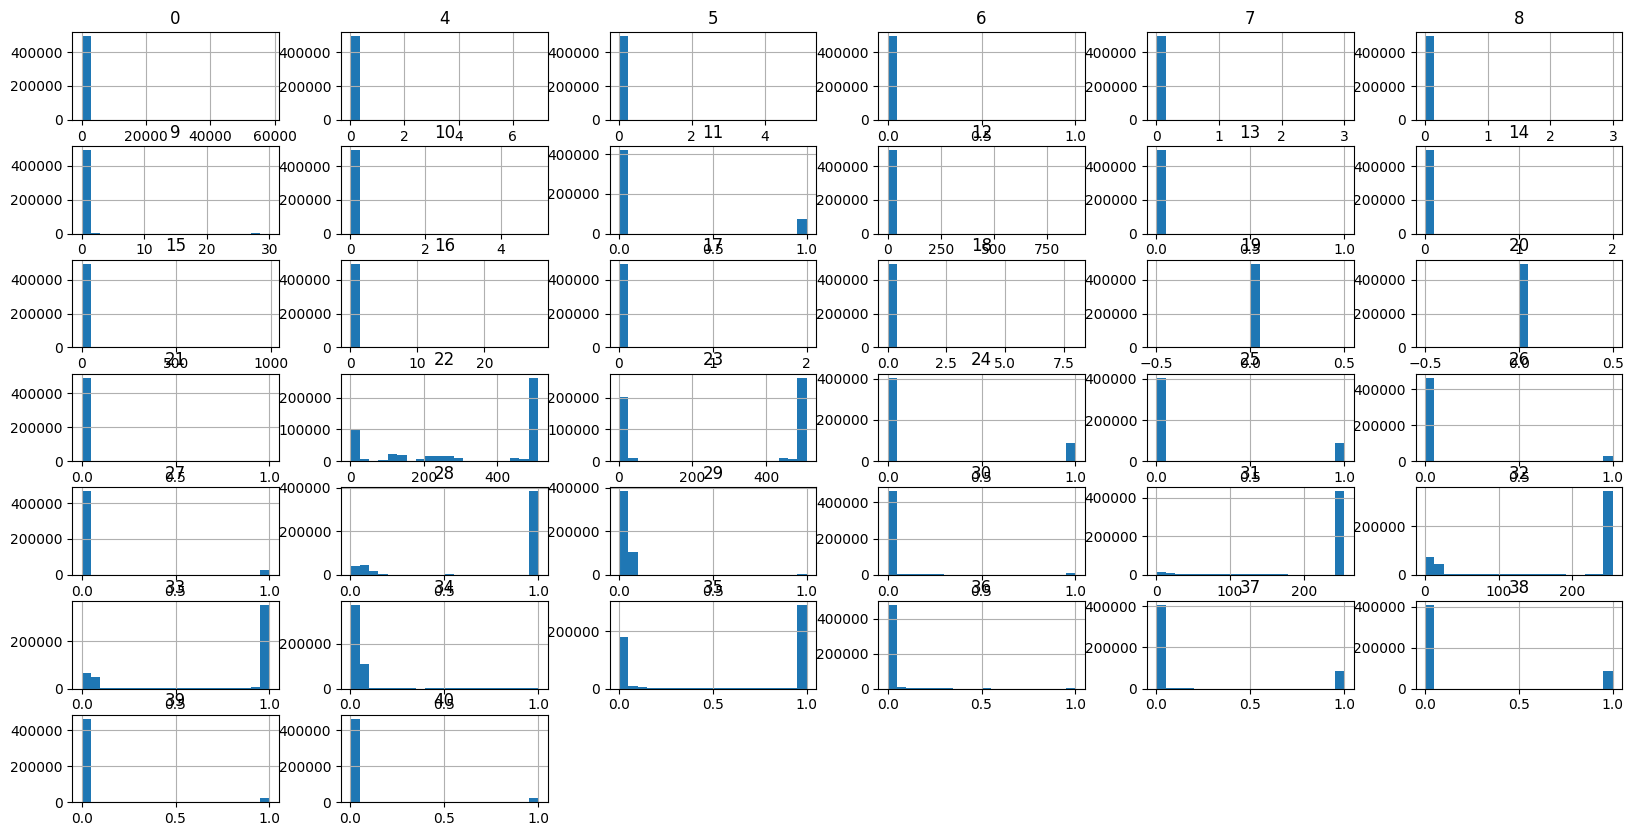

In [ ]:
data.hist(bins=20, figsize=(20, 10))
plt.title("Histogram")
plt.show()

In [ ]:
features = [4, 5, 22, 23]  # src_bytes, dst_bytes, count, srv_count

model = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, random_state=42)
model.fit(data[features])

IsolationForest(contamination=0.1, random_state=42)

In [17]:
data['anamoly'] = model.predict(data[features])
data['anamoly'] = data['anamoly'].apply(lambda x: 'Anamoly' if x == -1 else 'Normal')
data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,anamoly
0,0,tcp,http,SF,181,5450,0,0,0,0,...,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,normal.,Normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,normal.,Normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.,Normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.,Normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.,Normal
5,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.,Normal
6,0,tcp,http,SF,212,1940,0,0,0,0,...,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0,normal.,Normal
7,0,tcp,http,SF,159,4087,0,0,0,0,...,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0,normal.,Normal
8,0,tcp,http,SF,210,151,0,0,0,0,...,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0,normal.,Normal
9,0,tcp,http,SF,212,786,0,0,0,1,...,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0,normal.,Normal


In [29]:
# Install dependencies if needed (uncomment below)
# !pip install kagglehub pandas numpy scikit-learn tensorflow

# Step 1: Download KDD Cup 1999 dataset
path = kagglehub.dataset_download("galaxyh/kdd-cup-1999-data")
print("Path to dataset files:", path)

# Step 2: Load dataset
file_path = f"{path}/kddcup.data_10_percent_corrected"
column_names = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment",
    "urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell",
    "su_attempted","num_root","num_file_creations","num_shells","num_access_files",
    "num_outbound_cmds","is_host_login","is_guest_login","count","srv_count",
    "serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"
]
df = pd.read_csv(file_path, names=column_names)

# Step 3: Convert labels to binary (normal = 0, attack = 1)
df['label'] = df['label'].apply(lambda x: 0 if x == 'normal.' else 1)

# Step 4: Encode categorical features
categorical_cols = ['protocol_type', 'service', 'flag']
df[categorical_cols] = df[categorical_cols].apply(LabelEncoder().fit_transform)

# Step 5: Normalize the data
X = df.drop('label', axis=1)
y = df['label']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ------------------ Isolation Forest ------------------ #
print("\n[+] Running Isolation Forest...")
iso_forest = IsolationForest(contamination=0.2, random_state=42)
iso_preds = iso_forest.fit_predict(X_scaled)
iso_preds = np.where(iso_preds == -1, 1, 0)

print("[*] Isolation Forest Results:")
print(confusion_matrix(y, iso_preds))
print(classification_report(y, iso_preds))

# ------------------ Autoencoder ------------------ #
print("\n[+] Running Autoencoder...")

# Step 6: Build Autoencoder Model
input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Step 7: Train Autoencoder only on normal data
X_normal = X_scaled[y == 0]
X_anomaly = X_scaled[y == 1]

early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
autoencoder.fit(X_normal, X_normal, epochs=50, batch_size=256, shuffle=True, callbacks=[early_stop], verbose=1)

# Step 8: Compute reconstruction error
X_reconstructed = autoencoder.predict(X_scaled)
reconstruction_error = np.mean(np.square(X_scaled - X_reconstructed), axis=1)

# Step 9: Set threshold and predict
threshold = np.percentile(reconstruction_error, 95)
autoencoder_preds = np.where(reconstruction_error > threshold, 1, 0)

print("[*] Autoencoder Results:")
print(confusion_matrix(y, autoencoder_preds))
print(classification_report(y, autoencoder_preds))


Path to dataset files: /kaggle/input/kdd-cup-1999-data

[+] Running Isolation Forest...
[*] Isolation Forest Results:
[[ 55563  41715]
 [339656  57087]]
              precision    recall  f1-score   support

           0       0.14      0.57      0.23     97278
           1       0.58      0.14      0.23    396743

    accuracy                           0.23    494021
   macro avg       0.36      0.36      0.23    494021
weighted avg       0.49      0.23      0.23    494021


[+] Running Autoencoder...
Epoch 1/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0966
Epoch 2/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0058
Epoch 3/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0034
Epoch 4/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0024
Epoch 5/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0021
Epoch 6/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0019
Epoch 7/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018
Epoch 8/50
380/380 ━━━━

In [30]:
from sklearn.metrics import accuracy_score

# --- Isolation Forest Accuracy ---
iso_accuracy = accuracy_score(y, iso_preds)
print(f"[+] Isolation Forest Accuracy: {iso_accuracy:.4f}")

# --- Autoencoder Accuracy ---
auto_accuracy = accuracy_score(y, autoencoder_preds)
print(f"[+] Autoencoder Accuracy: {auto_accuracy:.4f}")


[+] Isolation Forest Accuracy: 0.2280
[+] Autoencoder Accuracy: 0.2469
